# **Detection of IoT botnet attacks**

Dataset: http://archive.ics.uci.edu/ml/datasets/detection_of_IoT_botnet_attacks_N_BaIoT

**About the problem:**

One of the biggest problems of IoT today is security. People say "S" in "IoT" stands for security. IoT is plagued by an epidemic of botnets, caused by very weak protection on most devices, such as smart security cameras, smart doorbells, smart thermometers, etc. These botnet are then used for various network attacks. It's very important to catch the infection as early as possible.

This datasets aims at distinguishing between benign and malicious traffic data by means of anomaly detection techniques. Malicious data can be divided into 10 attacks carried by 2 botnets (BASHLITE and mirai). There are a total of 9 IoT devices used in this dataset. Rows in the dataset represent features found in time windows of a packet stream: a total of 23 features are extracted from a single window, there are total of five windows: 100ms, 500ms, 1.5sec, 10sec, and 1min into the past (λ = 5, 3, 1, 0.1, 0.01), thus totaling 115 features per row.

We have decided to focus on predicting whether on not traffic coming from a device is malitious. After finding a good set of features and a good estimator, we will train the model on one device and test it on the other in order to prove that prediction works.

In [1]:
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.feature_selection import SelectKBest, f_classif

%matplotlib inline
warnings.filterwarnings('ignore')

sns.set()

In [2]:
#These will get rid of "..." in output of methods like .describe()
#I commented them out because they seem to cause trouble on github.

#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

As the dataset is very large, we repacked the data a bit (we included the sample we used in our submission).

Function bellow reads the data on one device and adds labels to it.

In [3]:
#returns a dataframe constructed from data of ONE device

#folderpath -       path to the data folder

#BASHLITE_only -    whether function will use only BASHLITE data, or both BASHLITE and mirai.

#equalize_classes - 0) off
#                   1) BASHLITE and mirai will get squished to the size of Bening,
#                   so all classes will have roughly the same size.
#                   2) will take next arg for what size should the botnets be compared to benign 
#                   (i.e. 0.3 will provide botnet data with a 30% of benign data size) BASHLITE and 
#                   mirai will always be equal to each other in size. Useful for making datasets 
#                   imbalanced toward benign.
#
#botnet_size        (float) see above

def read_device_data(folderpath, BASHLITE_only=False, equalize_classes=1, botnet_size=0.5):
    df_benign = pd.read_csv(folderpath + 'benign_traffic.csv')
    df_bashlite = [pd.DataFrame for i in range(5)]
    df_mirai = [pd.DataFrame for i in range(5)]
    df_bashlite[0] = pd.read_csv((folderpath + 'combo_bashlite.csv'))
    df_bashlite[1] = pd.read_csv((folderpath + 'junk_bashlite.csv'))
    df_bashlite[2] = pd.read_csv((folderpath + 'scan_bashlite.csv'))
    df_bashlite[3] = pd.read_csv((folderpath + 'tcp_bashlite.csv'))
    df_bashlite[4] = pd.read_csv((folderpath + 'udp_bashlite.csv'))
    if(not(BASHLITE_only)):
        df_mirai[0] = pd.read_csv((folderpath + 'ack_mirai.csv'))
        df_mirai[1] = pd.read_csv((folderpath + 'scan_mirai.csv'))
        df_mirai[2] = pd.read_csv((folderpath + 'syn_mirai.csv'))
        df_mirai[3] = pd.read_csv((folderpath + 'udpplain_mirai.csv'))
        df_mirai[4] = pd.read_csv((folderpath + 'udp_mirai.csv'))
    benign_size = df_benign.shape[0]
    print("size of benign :", benign_size)
    bashlite_size = 0
    mirai_size = 0
    for i in range(5):
        bashlite_size += df_bashlite[i].shape[0]
    print("full size of BASHLITE :", bashlite_size)
    if(not(BASHLITE_only)):
        for i in range(5):
            mirai_size += df_mirai[i].shape[0]
        print("full size of mirai :", mirai_size)
    if(equalize_classes != 0):
        bashlite_border = 0
        mirai_border = 0
        if(equalize_classes == 1):  
            bashlite_border = bashlite_size / benign_size
            if(not(BASHLITE_only)):
                mirai_border = mirai_size / benign_size
        if(equalize_classes == 2):
            if(BASHLITE_only):
                bashlite_border = int(benign_size * botnet_size)
                bashlite_border = bashlite_size / bashlite_border
            else:
                bashlite_border = int(benign_size * botnet_size / 2)
                bashlite_border = bashlite_size / bashlite_border
                mirai_border = int(benign_size * botnet_size / 2)
                mirai_border = mirai_size / mirai_border
        for i in range(5):
            amount = int(df_bashlite[i].shape[0] // bashlite_border)
            #print(amount)
            df_bashlite[i] = shuffle(df_bashlite[i])
            df_bashlite[i].drop(df_bashlite[i].index[amount:], inplace=True)
            if(not(BASHLITE_only)):
                amount = int(df_mirai[i].shape[0] // mirai_border)
                #print(amount)
                df_mirai[i] = shuffle(df_mirai[i])
                df_mirai[i].drop(df_mirai[i].index[amount:], inplace=True)
        bashlite_size = 0
        for i in range(5):
            bashlite_size += df_bashlite[i].shape[0]
        print("squished size of BASHLITE :", bashlite_size)
        if(not(BASHLITE_only)):
            mirai_size = 0
            for i in range(5):
                mirai_size += df_mirai[i].shape[0]
            print("squished size of mirai :", mirai_size)
    df_benign['Botnet'] = 1
    df_botnet = pd.concat(df_bashlite, ignore_index=True)
    df_botnet['Botnet'] = -1
    if(not(BASHLITE_only)):
        df_botnet_mirai = pd.concat(df_mirai, ignore_index=True)
        df_botnet_mirai['Botnet'] = -1
        df_botnet = pd.concat([df_botnet, df_botnet_mirai], ignore_index=True)
    
    res = pd.concat([df_benign, df_botnet], ignore_index=True)
    res = shuffle(res)
    print("full dataframe size :", res.shape[0])
    return res

In [4]:
data = read_device_data('.\\data\\doorbell\\',  BASHLITE_only=True)

size of benign : 40395
full size of BASHLITE : 316650
squished size of BASHLITE : 40393
full dataframe size : 80788


In [5]:
pd.set_option('display.max_columns', None)
data.describe()

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,MI_dir_L0.1_mean,MI_dir_L0.1_variance,MI_dir_L0.01_weight,MI_dir_L0.01_mean,MI_dir_L0.01_variance,H_L5_weight,H_L5_mean,H_L5_variance,H_L3_weight,H_L3_mean,H_L3_variance,H_L1_weight,H_L1_mean,H_L1_variance,H_L0.1_weight,H_L0.1_mean,H_L0.1_variance,H_L0.01_weight,H_L0.01_mean,H_L0.01_variance,HH_L5_weight,HH_L5_mean,HH_L5_std,HH_L5_magnitude,HH_L5_radius,HH_L5_covariance,HH_L5_pcc,HH_L3_weight,HH_L3_mean,HH_L3_std,HH_L3_magnitude,HH_L3_radius,HH_L3_covariance,HH_L3_pcc,HH_L1_weight,HH_L1_mean,HH_L1_std,HH_L1_magnitude,HH_L1_radius,HH_L1_covariance,HH_L1_pcc,HH_L0.1_weight,HH_L0.1_mean,HH_L0.1_std,HH_L0.1_magnitude,HH_L0.1_radius,HH_L0.1_covariance,HH_L0.1_pcc,HH_L0.01_weight,HH_L0.01_mean,HH_L0.01_std,HH_L0.01_magnitude,HH_L0.01_radius,HH_L0.01_covariance,HH_L0.01_pcc,HH_jit_L5_weight,HH_jit_L5_mean,HH_jit_L5_variance,HH_jit_L3_weight,HH_jit_L3_mean,HH_jit_L3_variance,HH_jit_L1_weight,HH_jit_L1_mean,HH_jit_L1_variance,HH_jit_L0.1_weight,HH_jit_L0.1_mean,HH_jit_L0.1_variance,HH_jit_L0.01_weight,HH_jit_L0.01_mean,HH_jit_L0.01_variance,HpHp_L5_weight,HpHp_L5_mean,HpHp_L5_std,HpHp_L5_magnitude,HpHp_L5_radius,HpHp_L5_covariance,HpHp_L5_pcc,HpHp_L3_weight,HpHp_L3_mean,HpHp_L3_std,HpHp_L3_magnitude,HpHp_L3_radius,HpHp_L3_covariance,HpHp_L3_pcc,HpHp_L1_weight,HpHp_L1_mean,HpHp_L1_std,HpHp_L1_magnitude,HpHp_L1_radius,HpHp_L1_covariance,HpHp_L1_pcc,HpHp_L0.1_weight,HpHp_L0.1_mean,HpHp_L0.1_std,HpHp_L0.1_magnitude,HpHp_L0.1_radius,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,Botnet
count,80788.000000,80788.000000,8.078800e+04,80788.000000,80788.000000,8.078800e+04,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,8.078800e+04,80788.000000,80788.000000,8.078800e+04,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,8.078800e+04,80788.000000,8.078800e+04,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,8.078800e+04,80788.000000,80788.000000,80788.000000,80788.000000,8.078800e+04,80788.000000,8.078800e+04,8.078800e+04,80788.000000,80788.000000,80788.000000,8.078800e+04,80788.000000,8.078800e+04,8.078800e+04,8.078800e+04,80788.000000,80788.000000,80788.000000,80788.000000,8.078800e+04,8.078800e+04,8.078800e+04,80788.000000,8.078800e+04,8.078800e+04,80788.000000,8.078800e+04,8.078800e+04,80788.000000,8.078800e+04,8.078800e+04,80788.000000,8.078800e+04,8.078800e+04,80788.000000,8.078800e+04,8.078800e+04,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,8.078800e+04,80788.000000,8.078800e+04,80788.000000,80788.000000,80788.000000,80788.000000,8.078800e+04,80788.000000,8.078800e+04,8.078800e+04,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,8.078800e+04,8.078800e+04,80788.000000,80788.000000
mean,26.767706,79.056769,1.308252e+02,42.418975,79.059997,1.484816e+02,118.031455,79.283198,185.489844,944.517516,79.861717,260.118536,3196.672943,79.120971,278.833433,26.767706,79.056769,1.308252e+02,42.418975,79.059997,1.484816e+02,118.031455,79.283190,185.489952,944.517555,79.861526,260.119752,3196.673120,79.120456,278.835376,23.753650,79.011361,1.009471e-01,101.015823,1.737598e+01,0.174976,0.000107,38.318276,79.010498,0.161320,101.016195,1.925642e+01,0.243141,0.000262,109.659327,79.081283,7.521676e-01,101.104884,3.786672e+01,4.992661e-01,0.002216,892.696067,79.541706,3.185704e+00,101.828143,1.482932e+02,8.622168e+00,1.929060e-02,2842.317708,79.116071,3.693175,101.490571,2.163220e+02,2.21340

As we are planning to try ensembles of trees first, no data normalization is required.

Check if there any null values:

In [6]:
data.isnull().values.any()

False

No NaN values, no categorized data, and a lot of already extracted features. Very nice dataset.

Correlation of target:

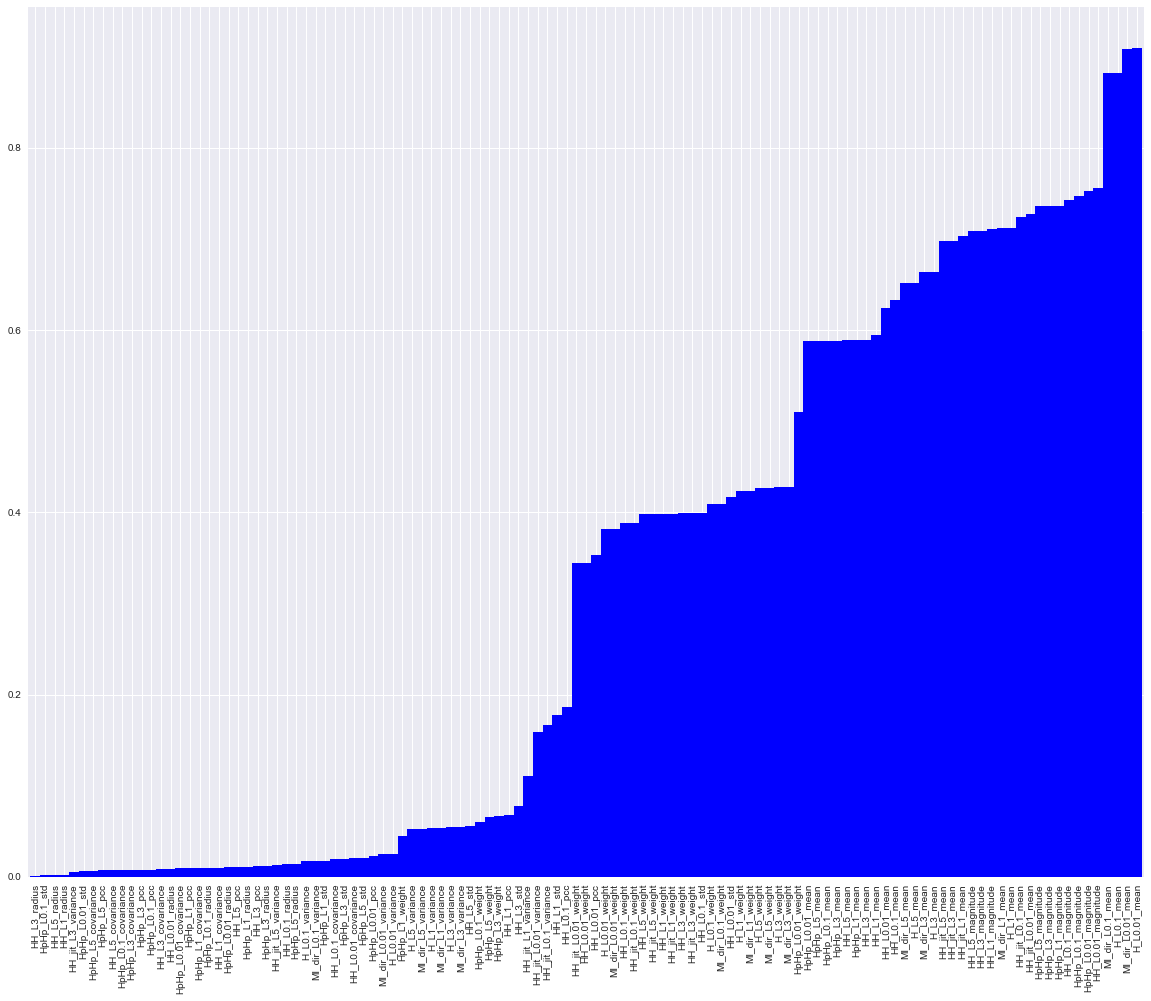

In [7]:
x = data.corr()['Botnet'].drop(['Botnet']).abs().sort_values(ascending=True)
fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(111)
x.plot(kind='bar', color='blue', ax=ax, width=1)
plt.show()

We see a srong correlation between "Botnet"(target) and "H_L0.1_mean", "H_L0.01_mean, "M_dir_L0.01_mean"

We are going to use RandomForest and Isolation Forest, because Isolation Forest is often used for detecting anomalies such as malicious traffic, and Randon Forest is in general very flexible and well-performing estimator

We will check feature importances for these two algorithms. 

First, for random forest. We have a large dataset, so we will check on smaller dataset.

In [8]:
y = data['Botnet']
X = data.drop(['Botnet'], axis=1)

In [9]:
clf = RandomForestClassifier()

clf.fit(X, y)
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance', ascending=True)

A bar plot of the most important features

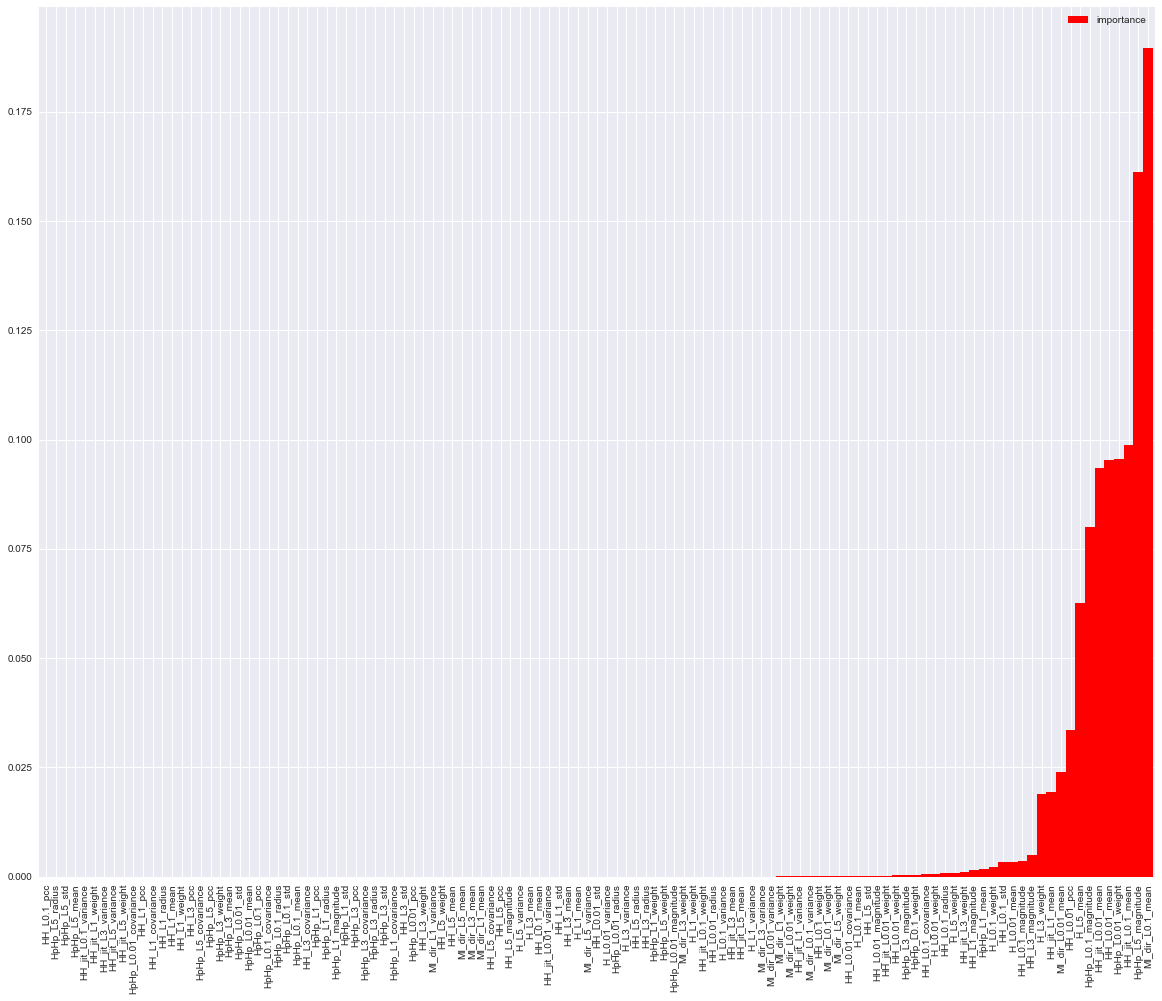

In [10]:
fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(111)
feature_importances.plot(kind='bar', color='red', ax=ax, width=1)
plt.show()

In [11]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(SelectKBest(f_classif, 11), 
                     clf)

scores = cross_val_score(pipe, X, y, scoring='f1_macro', cv=5)
print('Accuracy of classification is {:0.5f} +- {:0.5f}'.format(np.mean(scores), np.std(scores)))

Accuracy of classification is 0.99975 +- 0.00010


We got the highest score with 11 features. (We checked 7, 8, 9, 10, 12, 13, 14)

Now, for isolation forest

In [12]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

clf = IsolationForest()
selector = SelectKBest(f_classif, 11)
selector.fit(X, y)
# SelectKBest just selects the specified number of features with the highest scores 
print(X.shape)
data_reduced = selector.transform(X)

feature_names = list(X.columns.values)
mask = selector.get_support() #list of booleans
new_features = [] # The list of K best features

for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)
        
print(new_features)
print("-----------------------------------------------------------")
print(np.mean(cross_val_score(clf, data_reduced, y, cv=5, scoring='accuracy')))

(80788, 115)
['MI_dir_L0.1_mean', 'MI_dir_L0.01_mean', 'H_L0.1_mean', 'H_L0.01_mean', 'HH_L0.1_magnitude', 'HH_L0.01_magnitude', 'HpHp_L5_magnitude', 'HpHp_L3_magnitude', 'HpHp_L1_magnitude', 'HpHp_L0.1_magnitude', 'HpHp_L0.01_magnitude']
-----------------------------------------------------------
0.4751447339860893


I got the highest score with 11 features.Also I tried amount 7, 9, 10, 12, 13, 14, 20 features.

We got results: **from correlation:** "H_L0.1_mean", "H_L0.01_mean, "M_dir_L0.01_mean";


**from RF:** MI_dir_L0.1_mean, MI_dir_L0.01_mean, HpHp_L0.01_weight, H_L0.01_mean, HH_L0.01_magnitude, MI_dir_L0.1_mean, HH_L0.01_mean, HH_jit_L0.1_mean, HH_L0.1_mean, HpHp_L0.1_magnitude, HpHp_L1_magnitude, H_L0.01_weight.    


**from IF:** 'MI_dir_L1_mean', 'MI_dir_L0.1_mean', 'MI_dir_L0.01_mean', 'H_L1_mean', 'H_L0.1_mean', 'H_L0.01_mean', 'HH_jit_L5_mean', 'HH_jit_L3_mean', 'HH_jit_L1_mean', 'HH_jit_L0.1_mean', 'HH_jit_L0.01_mean'.

In [13]:
def drop_columns_rf(data):
    return pd.concat(([data['MI_dir_L0.1_mean'], 
                    data['MI_dir_L0.01_mean'], 
                    data['H_L0.01_mean'], 
                    data['HH_L0.1_magnitude'], 
                    data['HH_L0.01_magnitude'], 
                    data['HH_L0.01_mean'], 
                    data['HpHp_L0.01_mean'], 
                    data['HpHp_L1_magnitude'], 
                    data['HpHp_L1_mean'], 
                    data['H_L0.1_mean']]), axis=1)

In [14]:
def drop_columns_if(data):
    return pd.concat(([data['MI_dir_L0.1_mean'], 
                    data['MI_dir_L1_mean'], 
                    data['MI_dir_L0.01_mean'],
                    data['H_L1_mean'], 
                    data['H_L0.1_mean'], 
                    data['H_L0.01_mean'], 
                    data['HH_jit_L3_mean'], 
                    data['HH_jit_L1_mean'], 
                    data['HH_jit_L0.1_mean'], 
                    data['HH_jit_L0.01_mean']]), axis=1)

We see, that RF is better than IF. Let us look for a good set of hyperparameters.

In [15]:
y = data['Botnet']
X = drop_columns_rf(data)
X.shape

(80788, 10)

In [16]:
X.head(5)

,MI_dir_L0.1_mean,MI_dir_L0.01_mean,H_L0.01_mean,HH_L0.1_magnitude,HH_L0.01_magnitude,HH_L0.01_mean,HpHp_L0.01_mean,HpHp_L1_magnitude,HpHp_L1_mean,H_L0.1_mean
6360,93.985056,92.257160,92.257160,106.973020,107.035973,76.639559,98.000000,138.592929,98.000000,93.985056
21906,81.649733,92.478935,92.478935,119.396227,111.381387,77.849171,60.000000,84.852814,60.000000,81.649733
71236,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
58744,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
52390,76.140545,76.634835,76.634835,214.865490,755.021686,129.384260,69.996587,101.629004,69.659561,76.140545


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
X_train.shape

(60591, 10)

In [18]:
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier(random_state=0)

clf_params = [{ 
    "n_estimators": [2, 10, 50, 100],
    "min_samples_split": [2],
    "min_samples_leaf": [1, 2]
    
}]

clf_grid = GridSearchCV(clf, clf_params, cv=5, refit=True, verbose=1, n_jobs=-1)
clf_grid.fit(X_train, y_train)
clf_best = clf_grid.best_estimator_
print("Accuracy (random forest auto): {} with params {}"
      .format(clf_grid.best_score_, clf_grid.best_params_))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   44.0s finished


Accuracy (random forest auto): 0.9997194302784241 with params {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


[backup]Accuracy (random forest auto): 0.9998349589873083 with params {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50} <- grid search above sometimes outputs different params. We stuck with these.

In [19]:
clf_rfc = RandomForestClassifier(n_estimators=50,
 min_samples_split=2,
 min_samples_leaf=1)
scores = cross_val_score(clf_rfc, X_train, y_train, scoring='accuracy', cv=5)
print('RF score: {0:.3f} ± {1:.3f}'.format(scores.mean(), scores.std()) )

RF score: 1.000 ± 0.000


In [20]:
clf_rfc.fit(X_train, y_train)
y_pred = clf_rfc.predict(X_test)
print("accuracy: ", accuracy_score(y_test, y_pred))
print("f1 macro: ", f1_score(y_test, y_pred, average='macro'))
print("f1 micro: ", f1_score(y_test, y_pred, average='micro')) 
print("f1 weighted: ", f1_score(y_test, y_pred, average='weighted')) 
print("precision: ", precision_score(y_test, y_pred))
print("recall: ", recall_score(y_test, y_pred))

accuracy:  0.9998514630885775
f1 macro:  0.9998514629705981
f1 micro:  0.9998514630885775
f1 weighted:  0.9998514630820231
precision:  0.9998021369212505
recall:  0.9999010586722074


How does IF work here?

First, look for hyperparameters.

In [21]:
clf = IsolationForest()

#We have already had this grid search done, it took over 150 min. We had to re-run the notebook,
#so this is commented out for now and the best params are used in the next cell.
'''
clf_params = [{ 
    "n_estimators": [100, 200, 300, 400, 500],
    "max_samples": [50, 100, 200, 256, 300, 400, 500],
    "contamination": [0.1, 0.2, 0.3, 0.4, 0.5], 
    "random_state": [0]
    
}]


clf_grid = GridSearchCV(clf, clf_params, cv=5, scoring='accuracy', refit=True, verbose=1, n_jobs=-1)
clf_grid.fit(X_train, y_train)
clf_best = clf_grid.best_estimator_
print("Accuracy (isolation forest auto): {} with params {}"
      .format(clf_grid.best_score_, clf_grid.best_params_))
'''

'\nclf_params = [{ \n    "n_estimators": [100, 200, 300, 400, 500],\n    "max_samples": [50, 100, 200, 256, 300, 400, 500],\n    "contamination": [0.1, 0.2, 0.3, 0.4, 0.5], \n    "random_state": [0]\n    \n}]\n\n\nclf_grid = GridSearchCV(clf, clf_params, cv=5, scoring=\'accuracy\', refit=True, verbose=1, n_jobs=-1)\nclf_grid.fit(X_train, y_train)\nclf_best = clf_grid.best_estimator_\nprint("Accuracy (isolation forest auto): {} with params {}"\n      .format(clf_grid.best_score_, clf_grid.best_params_))\n'

[backup] Accuracy (isolation forest auto): 0.495411935569052 with params {'contamination': 0.1, 'max_samples': 50, 'n_estimators': 300, 'random_state': 0}

In [22]:
clf_ifc = IsolationForest(n_estimators=300, contamination=0.1, max_samples=50)
scores = cross_val_score(clf_ifc, X_train, y_train, scoring='accuracy', cv=5)
print('IF score: {0:.3f} ± {1:.3f}'.format(scores.mean(), scores.std()) )

IF score: 0.471 ± 0.023


In [23]:
clf_ifc.fit(X_train, y_train)
y_pred = clf_ifc.predict(X_test)
print('Accuracy of prediction is {}'.format(accuracy_score(y_test, y_pred)))

Accuracy of prediction is 0.44803683715403275


In [24]:
un, counts = np.unique(y_pred, return_counts=True)
print(np.asarray((un, counts)).T)

[[   -1  2090]
 [    1 18107]]


In [25]:
un, counts = np.unique(y_test, return_counts=True)
print(np.asarray((un, counts)).T)

[[   -1 10090]
 [    1 10107]]


Let us check our model on imbalanced dataset.

In [26]:
# upload new data from the other device
inbal_data = read_device_data('.\\data\\thermostat\\',  BASHLITE_only=True, equalize_classes=2, botnet_size=0.1)

size of benign : 13111
full size of BASHLITE : 310630
squished size of BASHLITE : 1309
full dataframe size : 14420


In [27]:
y_inbal = inbal_data['Botnet']
X_inbal = drop_columns_rf(inbal_data)
X_train, X_test, y_train, y_test = train_test_split(X_inbal, y_inbal, test_size=0.25, random_state=0)

First how about an already trained RFC?

In [28]:
y_pred = clf_rfc.predict(X_inbal)
print('Accuracy of prediction is {}'.format(accuracy_score(y_inbal, y_pred)))
print('f1_score_macro of prediction is {}'.format(f1_score(y_inbal, y_pred, average='macro')))
print('f1_score_micro of prediction is {}'.format(f1_score(y_inbal, y_pred, average='micro')))
print('f1_score_weighted of prediction is {}'.format(f1_score(y_inbal, y_pred, average='weighted')))

Accuracy of prediction is 0.28502080443828015
f1_score_macro of prediction is 0.2772837627371334
f1_score_micro of prediction is 0.28502080443828015
f1_score_weighted of prediction is 0.3384852145849442


Much better, but still lower that we would like it to be.

Now, in theory, isolation forest should work better on imbalanced data, however ours was trained on balanced dataset so it wont:

In [29]:
y_pred = clf_ifc.predict(X_inbal)
print('Accuracy of prediction is {}'.format(accuracy_score(y_inbal, y_pred)))
print('f1_score_macro of prediction is {}'.format(f1_score(y_inbal, y_pred, average='macro')))
print('f1_score_micro of prediction is {}'.format(f1_score(y_inbal, y_pred, average='micro')))
print('f1_score_weighted of prediction is {}'.format(f1_score(y_inbal, y_pred, average='weighted')))

Accuracy of prediction is 0.632871012482663
f1_score_macro of prediction is 0.3977460686372196
f1_score_micro of prediction is 0.632871012482663
f1_score_weighted of prediction is 0.7057310394767227


A test on new RFC: let us check the model on only benign and malicious data.
First, malicious.

In [30]:
path = ".\\data\\thermostat\\udp_bashlite.csv"
udp = pd.read_csv(path)
udp = shuffle(udp)
udp = drop_columns_rf(udp)
y_anom = np.empty(udp.shape[0])
y_anom.fill(-1)
y_anom

array([-1., -1., -1., ..., -1., -1., -1.])

In [31]:
y_pred = clf_rfc.predict(udp)
print('Accuracy of prediction is {}'.format(accuracy_score(y_anom, y_pred)))
print('f1_micro of prediction is {}'.format(f1_score(y_anom, y_pred, average='micro')))
print('f1_macro of prediction is {}'.format(f1_score(y_anom, y_pred, average='macro')))

Accuracy of prediction is 0.9996278306343102
f1_micro of prediction is 0.9996278306343102
f1_macro of prediction is 0.49990694034160055


Now, on benign.

In [32]:
path = ".\\data\\thermostat\\benign_traffic.csv"
ben = pd.read_csv(path)
ben = shuffle(ben)
ben = drop_columns_rf(ben)
y_ben = np.empty(ben.shape[0])
y_ben.fill(1)
y_ben

array([1., 1., 1., ..., 1., 1., 1.])

In [33]:
y_pred = clf_rfc.predict(ben)
print('Accuracy of prediction is {}'.format(accuracy_score(y_ben, y_pred)))
print('f1_micro of prediction is {}'.format(f1_score(y_ben, y_pred, average='micro')))
print('f1_macro of prediction is {}'.format(f1_score(y_ben, y_pred, average='macro')))

Accuracy of prediction is 0.21363740370681109
f1_micro of prediction is 0.21363740370681109
f1_macro of prediction is 0.1760306686777275


Now we can understand that our model makes mistakes on benign traffic. It puts -1 when it is 1 frequently.

Lets train IF on inbalanced data.

In [34]:
inbal_data = read_device_data('.\\data\\doorbell\\',  BASHLITE_only=True, equalize_classes=2, botnet_size=0.1)

size of benign : 40395
full size of BASHLITE : 316650
squished size of BASHLITE : 4036
full dataframe size : 44431


In [35]:
inbal_y = inbal_data['Botnet']
inbal_data = inbal_data.drop(['Botnet'], axis=1)
inbal_data.shape

(44431, 115)

In [36]:
from sklearn.model_selection import StratifiedKFold

clf = IsolationForest()
selector = SelectKBest(f_classif, 11)
selector.fit(inbal_data, inbal_y)
# SelectKBest just selects the specified number of features with the highest scores 
print(inbal_data.shape)
data_reduced = selector.transform(inbal_data)

feature_names = list(inbal_data.columns.values)
mask = selector.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)
        
print(new_features)
print("-----------------------------------------------------------")
cv = StratifiedKFold(n_splits=5, random_state=0)
print(np.mean(cross_val_score(clf, data_reduced, inbal_y, cv=cv, scoring='accuracy')))
print(np.mean(cross_val_score(clf, data_reduced, inbal_y, cv=cv, scoring='f1_macro')))
print(np.mean(cross_val_score(clf, data_reduced, inbal_y, cv=cv, scoring='f1_micro')))

(44431, 115)
['MI_dir_L0.1_mean', 'MI_dir_L0.01_mean', 'H_L0.1_mean', 'H_L0.01_mean', 'HH_L0.1_magnitude', 'HH_L0.01_magnitude', 'HH_jit_L5_mean', 'HH_jit_L3_mean', 'HH_jit_L1_mean', 'HH_jit_L0.1_mean', 'HH_jit_L0.01_mean']
-----------------------------------------------------------
0.9874637016679346
0.9632890733637888
0.9875762509053769


We got better results.

We got 11 best features: 'MI_dir_L0.1_mean', 'MI_dir_L0.01_mean', 'H_L0.1_mean', 'H_L0.01_mean', 'HH_L0.1_magnitude', 'HH_L0.01_magnitude', 'HH_jit_L5_mean', 'HH_jit_L3_mean', 'HH_jit_L1_mean', 'HH_jit_L0.1_mean', 'HH_jit_L0.01_mean'

Changing drop function:

In [37]:
def drop_columns_inb(data):
    return pd.concat(([data['MI_dir_L0.1_mean'], 
                    data['HH_L0.01_magnitude'], 
                    data['MI_dir_L0.01_mean'],
                    data['HH_L0.1_magnitude'], 
                    data['H_L0.1_mean'], 
                    data['H_L0.01_mean'], 
                    data['HH_jit_L3_mean'], 
                    data['HH_jit_L1_mean'], 
                    data['HH_jit_L0.1_mean'], 
                    data['HH_jit_L0.01_mean']]), axis=1)

In [38]:
inbal_data = drop_columns_inb(inbal_data)
inbal_data.shape

(44431, 10)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(inbal_data, inbal_y, test_size=0.25, random_state=0)

In [40]:
clf = IsolationForest()
clf_params = [{ 
    "n_estimators": [50, 100, 200],
    "max_samples": [50, 100, 200, 256, 300],
    "contamination": [0.1, 0.2, 0.3], 
    "random_state": [0]
    
}]


clf_grid = GridSearchCV(clf, clf_params, cv=cv, scoring='f1_macro', refit=True, verbose=1, n_jobs=-1)
clf_grid.fit(X_train, y_train)
clf_best = clf_grid.best_estimator_
print("f1_macro (isolation forest auto): {} with params {}"
      .format(clf_grid.best_score_, clf_grid.best_params_))

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed: 10.9min finished


f1_macro (isolation forest auto): 0.9731873001607156 with params {'contamination': 0.1, 'max_samples': 100, 'n_estimators': 200, 'random_state': 0}


[backup]f1_macro (isolation forest auto): 0.9733802867987968 with params {'contamination': 0.1, 'max_samples': 200, 'n_estimators': 100, 'random_state': 0}

In [41]:
clf_ifc_imba = IsolationForest(n_estimators=100, contamination=0.1, max_samples=200, random_state=0)
scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=cv)
print('IF score: {0:.5f} ± {1:.5f}'.format(scores.mean(), scores.std()) )
scores = cross_val_score(clf, X_train, y_train, scoring='f1_macro', cv=cv)
print('IF score: {0:.5f} ± {1:.5f}'.format(scores.mean(), scores.std()) )
scores = cross_val_score(clf, X_train, y_train, scoring='f1_micro', cv=cv)
print('IF score: {0:.5f} ± {1:.5f}'.format(scores.mean(), scores.std()) )

IF score: 0.98893 ± 0.00113
IF score: 0.96894 ± 0.00398
IF score: 0.98878 ± 0.00135


In [42]:
clf_ifc_imba.fit(X_train, y_train)
y_pred = clf_ifc_imba.predict(X_test)
print('Accuracy of prediction is {}'.format(accuracy_score(y_test, y_pred)))
print('f1_micro of prediction is {}'.format(f1_score(y_test, y_pred, average='micro')))
print('f1_macro of prediction is {}'.format(f1_score(y_test, y_pred, average='macro')))

Accuracy of prediction is 0.9892870003601009
f1_micro of prediction is 0.9892870003601009
f1_macro of prediction is 0.9693984848794573


Lets try them on a large dataset of previously not seen device


In [43]:
bal_data = read_device_data('.\\data\\Provision_PT_838_Security_Camera\\',
                            BASHLITE_only=True, equalize_classes=1)

size of benign : 98514
full size of BASHLITE : 309040
squished size of BASHLITE : 98513
full dataframe size : 197027


In [44]:
y_bal = bal_data['Botnet']
X_bal = drop_columns_rf(bal_data)

In [45]:
y_pred = clf_rfc.predict(X_bal)
print('Accuracy of prediction is {}'.format(accuracy_score(y_bal, y_pred)))
print('f1_micro of prediction is {}'.format(f1_score(y_bal, y_pred, average='micro')))
print('f1_macro of prediction is {}'.format(f1_score(y_bal, y_pred, average='macro')))

Accuracy of prediction is 0.8282976444852735
f1_micro of prediction is 0.8282976444852735
f1_macro of prediction is 0.823093543804172


In [46]:
inbal_data = read_device_data('.\\data\\Provision_PT_838_Security_Camera\\',  BASHLITE_only=True, equalize_classes=2, botnet_size=0.1)

size of benign : 98514
full size of BASHLITE : 309040
squished size of BASHLITE : 9849
full dataframe size : 108363


In [47]:
y_inbal = inbal_data['Botnet']
X_inbal = drop_columns_inb(inbal_data)

In [48]:
y_pred = clf_ifc_imba.predict(X_inbal)
print('Accuracy of prediction is {}'.format(accuracy_score(y_inbal, y_pred)))
print('f1_micro of prediction is {}'.format(f1_score(y_inbal, y_pred, average='micro')))
print('f1_macro of prediction is {}'.format(f1_score(y_inbal, y_pred, average='macro')))

Accuracy of prediction is 0.3615809824386553
f1_micro of prediction is 0.3615809824386553
f1_macro of prediction is 0.34025189099404174


In [49]:
un, counts = np.unique(y_pred, return_counts=True)
print(np.asarray((un, counts)).T)

[[   -1 79030]
 [    1 29333]]


It seems like isolation forest is either overfitting, or in general doesn't work well with new data. It marked most of the data as an anomaly.

## Conclusion

We tested a model that can potentially detect the malicious traffic coming out of an IoT device, which can help with the epidemic of IoT botnets.

We tried two estimators, random forest and isolation forest. As it turns out, they both have their pros and cons: when the sample has a malicious-to-benign data ratio close to 1:1, random forest works best while the isolation forest is rather (very) bad; but when there isn't that many malicious packet streams, isolation forest due to its anomaly searching capabilities overtakes random forest in performance. **However**: it is seems like isolation forest either has a huge problem with overfitting which we weren't able to solve in time, or in general does not work good with new data, as it marked most of the new data as anomality. With that in mind, it can be said that random forest is better when IoT device is actively used in an attack, and isolation forest is better when the device is trying to quietly infect other network nodes, but only if it was fitted for the device (which is very inconvenient and not practical).